In [1]:
%matplotlib inline

/data/vision/torralba/naturally_robust_models/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import torch
import torch.nn as nn
import timm
import numpy as np
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import robustbench

device = torch.device('cuda', 5)

/data/vision/torralba/naturally_robust_models/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [3]:
def abs_normalize(x, q=None, start_dim=-3):
  s = torch.quantile(x.abs().flatten(start_dim=start_dim), q=max(q, 1-q), dim=-1, keepdim=False)
  x = 0.5 + 0.5 * x/s[(..., ) + (None,)*(-start_dim)]

  x = torch.clamp(x, 0., 1.)
  return x
  
def plot_side_by_side_normalize(*images, normalize):
  plt.figure(figsize=(20,20))
  assert len(images) == len(normalize)
  columns = len(images)
  for i, image in enumerate(images):
      plt.subplot(len(images) // columns + 1, columns, i + 1)
      image = image.detach()
      with torch.no_grad():
        if image.shape[-1] > 3:
          image = image.permute(1, 2, 0)
        if normalize[i]:
          image = abs_normalize(image, q=0.01)
        plt.imshow(image, cmap='gray')

In [4]:
from typing import Callable, Any

def get_output(module, input, output):
    return output

def get_input(module, input, output):
    return input

def get_input_output(module, input, output):
    return input, output

def get_module_input_output(module, input, output):
    return module, input, output

def register_hook_fn_to_module(model: nn.Module, module_name: str, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        if module_name == name:
            handle = m.register_forward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
            return handle, results_dict

def register_bkw_hook_fn_to_module(model: nn.Module, module_name: str, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        if module_name == name:
            handle = m.register_full_backward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
            return handle, results_dict

def register_hook_fn_to_all_modules(model: nn.Module, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        _ = m.register_forward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
    return results_dict

def register_bkw_hook_fn_to_all_modules(model: nn.Module, hook_fn: Callable[[nn.Module, torch.Tensor, torch.Tensor], Any]):
    results_dict = {}
    for name, m in model.named_modules():
        _ = m.register_full_backward_hook(_hook_fn_cntr(name, results_dict, hook_fn))
    return results_dict

def _hook_fn_cntr(name, activation_dict, hook_fn):
    def hook(model, input, output):
        activation_dict[name] = hook_fn(model, input, output)
    return hook

In [5]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


def replace_layers(model, old, new):
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)
            
        if isinstance(module, old):
            ## simple module
            setattr(model, n, new)

def add_imagenet_normalization(model):
  val_transform = create_transform(
    **resolve_data_config(model.pretrained_cfg, model=model),
    is_training=False,
  )

  normalize_transform = val_transform.transforms[-1]
  model = nn.Sequential(normalize_transform, model)
  return model

def load_model(path, ema=False):
    model_kwargs=dict({
            'num_classes': 1000,
            'drop_rate': 0.0,
            'drop_path_rate': 0.0,
            'drop_block_rate': None,
            'global_pool': None,
            'bn_momentum': None,
            'bn_eps': None,
    })
    if '_resnet_' in path:
      model = timm.models.create_model('resnet50', pretrained=False, **model_kwargs)
      if '_gelu' in path:
        replace_layers(model, nn.ReLU, nn.GELU())
    elif '_swinb' in path:
      model = timm.models.create_model('swin_base_patch4_window7_224', pretrained=False, **model_kwargs)
    elif '_swins' in path:
      model = timm.models.create_model('swin_small_patch4_window7_224', pretrained=False, **model_kwargs)
    ckpt = torch.load(path, map_location='cpu')
    if ema:
      if 'state_dict_ema' in ckpt:
        model.load_state_dict(ckpt['state_dict_ema'])
      else:
        return None
    else:
      model.load_state_dict(ckpt['state_dict'])

    model = add_imagenet_normalization(model)
    return model.eval().cpu()

def load_public_model(model_name):
  if model_name[0].isupper():
    return robustbench.utils.load_model(model_name, dataset='imagenet', threat_model='Linf').to(device)
  else:
    if 'random' in model_name:
      return add_imagenet_normalization(timm.create_model(model_name[:-len('_random')], pretrained=False).eval()).cpu()
    else:
      return add_imagenet_normalization(timm.create_model(model_name, pretrained=True).eval()).cpu()

## Data

In [6]:
data = torch.load('analysis_data/240206_gen_imagenet_data_10k_noattack.pth', map_location='cpu')
# xs = torch.load('/data/vision/torralba/naturally_robust_models/input_norm/outputs/inputs/train_png/inputs.pth')
# ys = torch.load('/data/vision/torralba/naturally_robust_models/input_norm/outputs/inputs/train_png/targets.pth')
# data = {'xs':xs, 'ys':ys}

In [7]:
data.keys()

dict_keys(['xs', 'ys', 'at_outs', 'at_grads', 'gn_outs', 'gn_grads', 'sampler_indices'])

In [8]:
xs = data['xs']
ys = data['ys']

N = 10000
xs = xs[:N]
ys = ys[:N]

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

val_transform = create_transform(
    **resolve_data_config(model.pretrained_cfg, model=model),
    is_training=False,
  )

normalize_transform = val_transform.transforms[-1]

if xs.min() < 0:
  xs = xs*normalize_transform.std[None, :, None, None] + normalize_transform.mean[None, :, None, None]

sampler_indices = range(N)
ds = torch.utils.data.TensorDataset(xs, ys)

from tqdm.auto import tqdm

dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=1,
    sampler=sampler_indices,
    shuffle=False
)

def get_activations(module_name, model_path=None, model_name=None):
  if model_path:
    model = load_model(model_path)
  elif model_name:
    model = load_public_model(model_name)

  model = model.to(device)

  handle, act_dict = register_hook_fn_to_module(model, module_name, get_input_output)
  
  outs = []
  grads = []
  act_inputs = []
  act_outputs = []

  for ii, (x, y) in enumerate(tqdm(dataloader)):
      x, y = x.to(device), y.to(device)
      x.requires_grad_(True)

      # Clean at
      out = model(x)#.cpu()
      loss = torch.nn.functional.cross_entropy(out, y)
      act_input = act_dict[module_name][0][0].detach().cpu()
      act_output = act_dict[module_name][1][0].detach().cpu() if isinstance(act_dict[module_name][1], tuple) else act_dict[module_name][1].detach().cpu()
      grad_x = torch.autograd.grad(loss, x, create_graph=False, retain_graph=False)[0].detach().cpu() #.abs().sum(1, keepdim=True)
      #logit = out[torch.arange(out.size(0)), y].sum()
      #grad_x = torch.autograd.grad(logit, x, create_graph=False, retain_graph=False)[0].detach().cpu().abs().max(1, keepdim=True).values

      outs.append(out.detach().cpu())
      grads.append(grad_x)
      act_inputs.append(act_input)
      act_outputs.append(act_output)
  
  outs = torch.cat(outs, 0)
  grads = torch.cat(grads, 0)
  act_inputs = torch.cat(act_inputs, 0)
  act_outputs = torch.cat(act_outputs, 0)
  handle.remove()

  model = model.to('cpu')

  return outs, grads, act_inputs, act_outputs

/data/vision/torralba/naturally_robust_models/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
import torchattacks

def measure_interpolated_loss(model_path=None, model_name=None, n=16):
    if model_path:
        model = load_model(model_path)
        print(model_path)
    elif model_name:
        model = load_public_model(model_name)
        print(model_name)

    losses = []
    grads = []
    hvp_norms = []

    model = model.to(device)

    atk = torchattacks.PGD(model, eps=4./255., steps=5)
    
    linspace = torch.linspace(0, 2, n)[:, None, None, None].to(device)
    model.eval()
    for ii, (x, y) in enumerate(tqdm(dataloader)):
        x, y = x.to(device), y.to(device)
        x.requires_grad_(True)

        atk_x = atk(x, y)

        x = torch.lerp(x[0], atk_x[0], linspace)
        y = torch.full((x.size(0),), y[0], device=y.device)
        x.requires_grad_(True)

        # Clean at
        out = model(x)#.cpu()
        loss = torch.nn.functional.cross_entropy(out, y, reduction='none')
        grad_x = torch.autograd.grad(loss.sum(), x, create_graph=True, retain_graph=True)[0]
        
        # u = (atk_x - x[0:1]).detach()
        u = grad_x
        u = u / torch.norm(u, p=2, dim=(1,2,3), keepdim=True)
        grad_vector_prod = (grad_x * u.detach_()).sum()
        hessian_vector_prod = torch.autograd.grad(outputs=grad_vector_prod, inputs=x)[0]
        hessian_qf = (hessian_vector_prod * u.detach_()).sum((1, 2, 3))
        hessian_nqf = hessian_qf.abs().div(torch.norm(grad_x, p=2, dim=(1, 2, 3)) + 1e-6)
        

        losses.append(loss.detach().cpu())
        grads.append(grad_x.abs().sum((-3, -2, -1)).detach().cpu())
        hvp_norms.append(hessian_nqf.detach().cpu())
        if ii == 100:
            x = None
            y = None
            atk_x = None
            break

    losses = torch.stack(losses, 0).mean(0)
    grads = torch.stack(grads, 0).mean(0)
    hvp_norms = torch.stack(hvp_norms).mean(0)

    model = model.to('cpu')
    atk = None

    return losses, grads, hvp_norms

In [43]:
import torchattacks

def measure_interpolated_loss(model_path=None, model_name=None, n=16, num_power_iter=2):
    if model_path:
        model = load_model(model_path)
        print(model_path)
    elif model_name:
        model = load_public_model(model_name)
        print(model_name)

    losses = []
    grads = []
    hvp_norms = []

    model = model.to(device)

    atk = torchattacks.PGD(model, eps=4./255., steps=5)

    dataloader = torch.utils.data.DataLoader(
        ds,
        batch_size=1,
        sampler=sampler_indices,
        shuffle=False
    )
    
    linspace = torch.linspace(0, 2, n)[:, None, None, None].to(device)
    model.eval()
    for ii, (x, y) in enumerate(tqdm(dataloader)):
        x, y = x.to(device), y.to(device)
        x.requires_grad_(True)

        atk_x = atk(x, y)

        x = torch.lerp(x[0], atk_x[0], linspace)
        y = torch.full((x.size(0),), y[0], device=y.device)
        x.requires_grad_(True)

        # Clean at
        out = model(x)#.cpu()
        loss = torch.nn.functional.cross_entropy(out, y, reduction='none')
        grad_x = torch.autograd.grad(loss.sum(), x, create_graph=True, retain_graph=True)[0]
        
        # Curvature
        gnorm = torch.norm(grad_x, p=2, dim=(1, 2, 3))
        u = grad_x.clone() #torch.randn_like(x)
        u /= torch.norm(u, p=2, dim=(1, 2, 3), keepdim=True)
        ## Power method to find singular value of Hessian
        for _ in range(num_power_iter):
            grad_vector_prod = (grad_x * u.detach_()).sum()
            hessian_vector_prod = torch.autograd.grad(outputs=grad_vector_prod, inputs=x, retain_graph=True)[0]
            assert not hessian_vector_prod.isnan().any()

            hvp_norm = torch.norm(hessian_vector_prod, p=2, dim=(1, 2, 3), keepdim=True)
            u = hessian_vector_prod.div(hvp_norm + 1e-6) #1e-6 for numerical stability
        grad_vector_prod = (grad_x * u.detach_()).sum()
        hessian_vector_prod = torch.autograd.grad(outputs=grad_vector_prod, inputs=x)[0]
        hessian_singular_value = (hessian_vector_prod * u.detach_()).sum((1, 2, 3))    
        # curvature = hessian_singular_value / (grad_norm + epsilon) by definition
        curvatures = hessian_singular_value.abs().div(gnorm + 1e-6)        

        losses.append(loss.detach().cpu())
        grads.append(grad_x.abs().sum((-3, -2, -1)).detach().cpu())
        hvp_norms.append(curvatures.detach().cpu())
        if ii == 1000:
            x = None
            y = None
            atk_x = None
            break

    losses = torch.stack(losses, 0).mean(0)
    grads = torch.stack(grads, 0).mean(0)
    hvp_norms = torch.stack(hvp_norms).mean(0)

    model = model.to('cpu')
    atk = None

    return losses, grads, hvp_norms

In [45]:
import torchattacks

def measure_accuracy(model_path=None, model_name=None, n=16, num_power_iter=2):
    if model_path:
        model = load_model(model_path)
        print(model_path)
    elif model_name:
        model = load_public_model(model_name)
        print(model_name)

    accs = []
    atk_accs = []

    model = model.to(device)

    atk = torchattacks.PGD(model, eps=4./255., steps=5)

    dataloader = torch.utils.data.DataLoader(
        ds,
        batch_size=25,
        sampler=sampler_indices,
        shuffle=False
    )
    
    linspace = torch.linspace(0, 2, n)[:, None, None, None].to(device)
    model.eval()
    for ii, (x, y) in enumerate(tqdm(dataloader)):
        x, y = x.to(device), y.to(device)

        out = model(x)
        acc = (out.argmax(-1) == y).float()
        accs.append(acc)

        atk_x = atk(x, y)
        atk_out = model(atk_x)
        atk_acc = (atk_out.argmax(-1) == y).float()
        atk_accs.append(atk_acc)
        if ii == 1000//25:
            x = None
            y = None
            atk_x = None
            break
    
    accs = torch.cat(accs, 0)
    atk_accs = torch.cat(atk_accs, 0)

    model = model.to('cpu')
    atk = None

    return accs.float().mean(), atk_accs.float().mean()

In [47]:
device = torch.device('cuda', 1)

In [48]:
measure_accuracy(model_name='swin_base_patch4_window7_224')

swin_base_patch4_window7_224


 10%|█         | 40/400 [00:37<05:35,  1.07it/s]


(tensor(0.8624, device='cuda:1'), tensor(0.0722, device='cuda:1'))

In [49]:
measure_accuracy(model_path=f'outputs/advtrain_swinb_orig/last.pth.tar')

eccv_outputs/advtrain_swinb_orig/last.pth.tar


 10%|█         | 40/400 [00:37<05:35,  1.07it/s]


(tensor(0.7571, device='cuda:1'), tensor(0.5922, device='cuda:1'))

In [50]:
measure_accuracy(model_path=f'outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar')

eccv_outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar


 10%|█         | 40/400 [00:37<05:36,  1.07it/s]


(tensor(0.7629, device='cuda:1'), tensor(0.5668, device='cuda:1'))

In [11]:
results_dict = {}

In [12]:
results_dict['natural'] = measure_interpolated_loss(model_name='swin_base_patch4_window7_224')

swin_base_patch4_window7_224


 10%|█         | 1000/10000 [16:36<2:29:25,  1.00it/s]


In [13]:
results_dict['advtrain'] = measure_interpolated_loss(model_path=f'outputs/advtrain_swinb_orig/last.pth.tar')

eccv_outputs/advtrain_swinb_orig/last.pth.tar


 10%|█         | 1000/10000 [16:42<2:30:21,  1.00s/it]


In [14]:
results_dict['gradnorm_strong'] = measure_interpolated_loss(model_path=f'outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar')

eccv_outputs/gradnorm_swinb_variant/2024-02-14_11-30-41/last.pth.tar


 10%|█         | 1000/10000 [17:04<2:33:40,  1.02s/it]


In [15]:
# results_dict['gradnorm_weak'] = measure_interpolated_loss(model_path=f'outputs/gradnorm_swinb_orig/last.pth.tar')

In [51]:
def plot_fn(k, plot_nat=True, **kwargs):
    _at_metric = results_dict['advtrain'][k].detach().cpu()
    _gn_strong_metric = results_dict['gradnorm_strong'][k].detach().cpu()
    _nat_metric = results_dict['natural'][k].detach().cpu()
    print(_at_metric.shape, _gn_strong_metric.shape)
    print(_at_metric.min(), _gn_strong_metric.min())
    
    n = _at_metric.size(0)
    linspace = torch.linspace(0, 2, n) * 4

    fig = plt.figure()
    
    plt.plot(
        linspace,
        _at_metric,
        label='Adversarial Training (PGD-3) (clean=75.71%, pgd-5=59.22%)',
        color='red'
    )
    plt.plot(
        linspace,
        _gn_strong_metric,
        label='Gradient Norm Regularization (clean=76.29%, pgd-5=56.68%)',
        color='blue',
    )
    if plot_nat:
        plt.plot(
            linspace,
            _nat_metric,
            label='Natural Training (clean=86.24%, pgd-5=07.22%)',
            color='Orange',
        )
    plt.ylabel(kwargs['ylabel'])
    plt.xlabel(r'$\ell_\infty$ of attack perturbation')
    plt.legend()

    return fig

torch.Size([16]) torch.Size([16])
tensor(1.1018) tensor(1.0430)


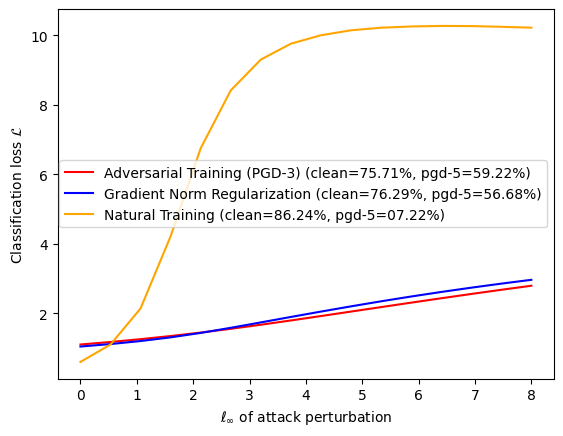

In [52]:
fig = plot_fn(k=0, plot_nat=True, ylabel=r'Classification loss $\mathcal{L}$')
fig.savefig('./figures_suppmat/attack_interpolation_loss.pdf', facecolor='white')

torch.Size([16]) torch.Size([16])
tensor(1.1018) tensor(1.0430)


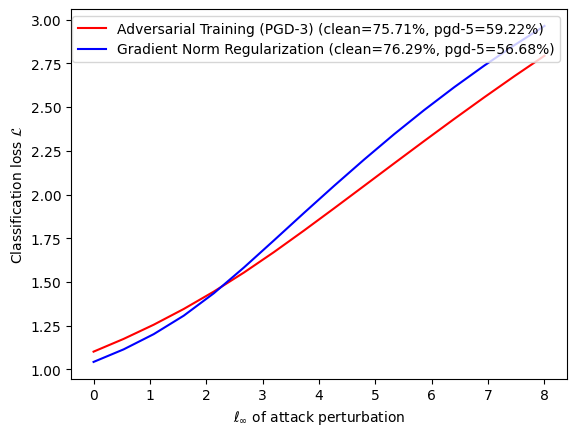

In [53]:
fig = plot_fn(k=0, plot_nat=False, ylabel=r'Classification loss $\mathcal{L}$')
fig.savefig('./figures_suppmat/attack_interpolation_loss_nonat.pdf', facecolor='white')

torch.Size([16]) torch.Size([16])
tensor(36.3968) tensor(37.3568)


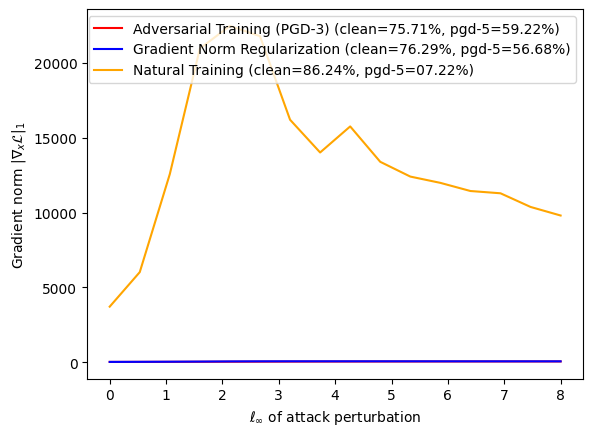

In [54]:
fig = plot_fn(k=1, plot_nat=True, ylabel=r'Gradient norm $|\nabla_x\mathcal{L}|_1$')
fig.savefig('./figures_suppmat/attack_interpolation_gradnorm.pdf', facecolor='white')

torch.Size([16]) torch.Size([16])
tensor(36.3968) tensor(37.3568)


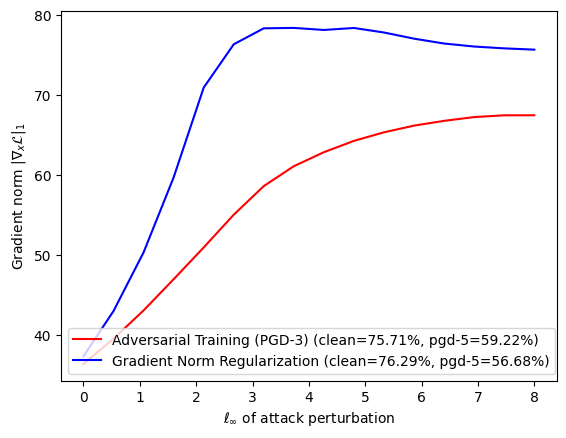

In [55]:
fig = plot_fn(k=1, plot_nat=False, ylabel=r'Gradient norm $|\nabla_x\mathcal{L}|_1$')
fig.savefig('./figures_suppmat/attack_interpolation_gradnorm_nonat.pdf', facecolor='white')

torch.Size([16]) torch.Size([16])
tensor(1.2971) tensor(1.3423)


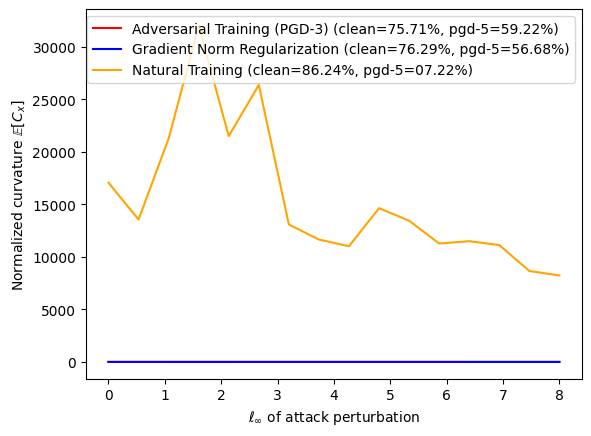

In [56]:
fig = plot_fn(k=2, plot_nat=True, ylabel=r'Normalized curvature $\mathbb{E}[C_x]$')
fig.savefig('./figures_suppmat/attack_interpolation_hessian.pdf', facecolor='white')

torch.Size([16]) torch.Size([16])
tensor(1.2971) tensor(1.3423)


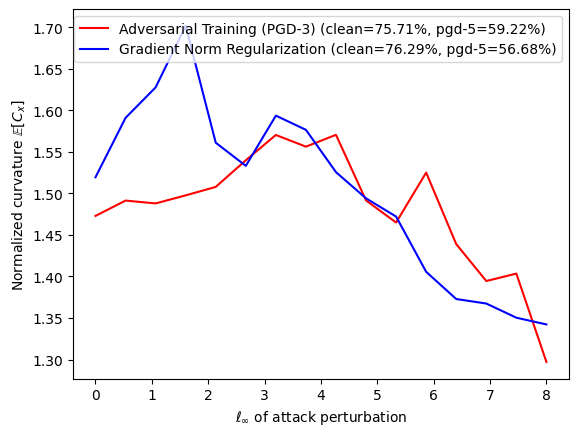

In [57]:
fig = plot_fn(k=2, plot_nat=False, ylabel=r'Normalized curvature $\mathbb{E}[C_x]$')
fig.savefig('./figures_suppmat/attack_interpolation_hessian_nomat.pdf', facecolor='white')